In [1]:
import os,time
import torch, tables
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']='9'

In [3]:
T = 10 # time buckets
file = "/mnt/fs1/tbenst/200623_faces/R1_E3_AMES_200min_200f_14l_rgb.h5"
hdf5 = tables.open_file(file,'r')
hdf5 = hdf5.root

cache_path = "/mnt/fs1/tbenst/200623_faces/R1_E3_AMES_200min_200f_14l_rgb_cache.npy"
try:
    dataset = np.load(cache_path)
except FileNotFoundError:

    data = []
    for i in range(7):
        print('.',end='')
        batch = np.array(hdf5['data'][i*400:(i+1)*400])
        batch = batch.reshape(-1,T,int(batch.shape[1]/T),64,64,6).sum(2).astype(np.float32) # binning
        data.append(batch)
        
    dataset = np.concatenate(data,axis=0)
    dataset = np.moveaxis(dataset,[0,1,2,3,4],[0,1,3,4,2])
    np.save(cache_path, dataset)

# Presented targets

In [8]:
imgs = hdf5["images"][0:100]
y,x = np.where(np.mean(imgs, axis=(0,3))>5)
xleft, xright, ytop, ybot = min(x), max(x), min(y), max(y)

images = hdf5["images"][:,ytop:ybot,xleft:xright]

tiny_images = []
for i in range(len(images)):
    tiny_images.append(cv2.resize(images[i],(64,64)))
images = np.stack(tiny_images)

# Model

In [9]:
class Block(torch.nn.Module):
    def __init__(self, filters):
        super(Block, self).__init__()
        
        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(filters, filters, 3, padding=1, bias=False),
            torch.nn.BatchNorm2d(filters), torch.nn.ReLU(),
            torch.nn.Conv2d(filters, filters, 3, padding=1, bias=False),
            torch.nn.BatchNorm2d(filters))
        
    def forward(self, x):
        return F.relu(x + self.block(x))
    
class ConvNet(torch.nn.Module):
    def __init__(self, filters=128):
        super(ConvNet, self).__init__()
        self.filters = filters
        
        self.conv_in = torch.nn.Conv2d(10*6, filters, 9, padding=4, stride=4, bias=False)
        
        self.resnet = torch.nn.ModuleList()
        for i in range(101): self.resnet.append(Block(filters))
            
        self.conv_out =  torch.nn.ConvTranspose2d(self.filters, 1, 8, stride=8, bias=True)
        self.bias = torch.nn.Parameter(torch.Tensor(64,64))
        
        for name, parm in self.named_parameters():
            if name.endswith('weight'): torch.nn.init.normal_(parm, 0, .01)
            if name.endswith('bias'): torch.nn.init.constant_(parm, 0.0)
    
    def forward(self, x):
        x = x.view(-1,10*6,64,64)[:,:,::2,::2].contiguous() # factor of 2 downsampling
        zx = F.relu(self.conv_in(x))
        for layer in self.resnet: zx = layer(zx)
        return torch.sigmoid(self.conv_out(zx).squeeze() + self.bias[None,:,:])

# Fit

In [10]:
data = torch.tensor(dataset)/30. # scaling
targets = torch.tensor(images).float().mean(3)/255.

In [11]:
train_data = data[[i for i in range(2800) if (i+1)%5 != 0]]
val_data = data[slice(4,2800,10)]
test_data = data[slice(9,2800,10)]

train_targets = targets[[i for i in range(2800) if (i+1)%5 != 0]]
val_targets = targets[slice(4,2800,10)]
test_targets = targets[slice(9,2800,10)]

In [18]:
batch_size = 50

model = ConvNet().cuda()
count = sum([np.prod(parm.shape) for parm in model.parameters() if parm.requires_grad])
print('Initialized a graph with {} parameters'.format(count))

train_history = []
val_history = []

model.eval()
loss = 0.
for i in np.random.permutation(len(val_data)//batch_size):
    start, end = i*batch_size, (i+1)*batch_size
    x,z = val_data[start:end].cuda(), val_targets[start:end].cuda()
    loss += ((model(x).detach() - z)**2).sum(1).mean()
val_history.append(loss/(len(val_data)//batch_size))
print('Initial Loss: {:2f}'.format(val_history[-1]))

Initialized a graph with 30472193 parameters
Initial Loss: 4.065810


In [13]:
batch_size = 50
optimizer = torch.optim.Adam(model.parameters(), lr=.0003)

try:
    print('epoch\ttrain loss\ttest loss\ttime\t\tutime')
    t0 = time.time()
    for epoch in range(500):
        model.train()
        loss_train = 0
        for i in np.random.permutation(len(train_data)//batch_size):
            start, end = i*batch_size, (i+1)*batch_size
            x,z = train_data[start:end].cuda(), train_targets[start:end].cuda()
            loss = ((model(x) - z)**2).sum(1).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.detach()
        train_history.append(loss_train/(len(train_data)//batch_size))

        if epoch % 1 == 0:
            t1 = time.time()
            model.eval()
            loss = 0.
            for i in range(len(val_data)//batch_size):
                start, end = i*batch_size, (i+1)*batch_size
                x,z = val_data[start:end].cuda(), val_targets[start:end].cuda()
                loss += ((model(x).detach() - z)**2).sum(1).mean()
            val_history.append(loss/(len(val_data)//batch_size))
            print('{:d}\t{:2f}\t{:2f}\t{:2f}\t{:2f}'.format(epoch,train_history[-1],val_history[-1],time.time()-t0, time.time()-t1))
            t0 = time.time()
            
except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print('Finished')

epoch	train loss	test loss	time		utime
0	2.413257	3.811503	11.641233	0.756482
1	1.278735	2.111242	10.668725	0.698970
2	1.030491	1.181813	10.367409	0.609463
3	0.934161	0.978225	9.318675	0.435663
4	0.805108	1.395514	8.365385	0.424883
5	0.738724	0.948572	8.677072	0.359145
6	0.660368	0.921575	9.218548	0.376374
7	0.614347	1.190214	9.248085	0.375625
8	0.569282	0.811549	9.445283	0.454688
9	0.534438	0.760004	9.559985	0.407224
10	0.514745	0.798089	9.193830	0.328262
11	0.495826	0.758964	9.109130	0.377933
12	0.485466	0.779930	8.176246	0.330829
13	0.465916	0.760025	8.618422	0.343900
14	0.427881	0.729307	8.075984	0.272608
15	0.418134	0.741213	8.115192	0.302433
16	0.418359	0.723280	7.461365	0.297921
17	0.380117	0.721601	7.619952	0.262215
18	0.369633	0.699238	7.915882	0.301583
19	0.366396	0.737255	7.725752	0.340606
20	0.342036	0.775703	7.605850	0.314202
21	0.334683	0.683307	8.073133	0.340581
22	0.335351	0.721268	8.001289	0.441061
23	0.325164	0.698756	7.506751	0.284233
24	0.325941	0.706813	6.903513	0.

206	0.052186	0.620920	7.605985	0.383795
207	0.050568	0.628257	7.630479	0.428497
208	0.048927	0.624595	7.526748	0.313722
209	0.049822	0.622364	7.172616	0.304316
210	0.050098	0.641484	7.180022	0.325309
211	0.052311	0.639634	7.498456	0.325323
212	0.052893	0.630271	7.512144	0.324470
213	0.054269	0.616732	7.526240	0.342608
214	0.054790	0.634718	7.921420	0.307299
215	0.055027	0.636687	8.208425	0.390802
216	0.057841	0.617617	7.520944	0.358546
217	0.059606	0.614436	7.550142	0.377679
218	0.060455	0.632738	8.046751	0.434389
219	0.058075	0.623006	8.782731	0.455462
220	0.054772	0.625534	9.674419	0.504910
221	0.051521	0.620951	9.524173	0.441473
222	0.050852	0.617368	9.623895	0.410078
223	0.048496	0.634798	9.244157	0.442425
224	0.047870	0.627625	8.983603	0.481063
225	0.050846	0.615810	9.267964	0.452929
226	0.051299	0.624283	8.868514	0.440089
227	0.050307	0.629222	9.403364	0.514653
228	0.050970	0.630892	9.863697	0.505996
229	0.050739	0.620834	8.928053	0.454184
230	0.054718	0.630879	9.221886	0.414062


411	0.020214	0.626288	7.543272	0.327444
412	0.021331	0.613317	7.609928	0.358628
413	0.021649	0.613623	8.195519	0.308892
414	0.021408	0.612488	7.764927	0.418724
415	0.021322	0.598823	7.448030	0.392073
416	0.021341	0.630940	7.563629	0.421347
417	0.021355	0.606805	7.803759	0.344204
418	0.021002	0.611091	8.188641	0.383235
419	0.020993	0.607417	7.864484	0.313401
420	0.021198	0.606359	7.521800	0.361273
421	0.021486	0.610027	7.307656	0.300911
422	0.022927	0.619625	7.277856	0.313348
423	0.023340	0.625613	7.132447	0.291788
424	0.024720	0.608081	7.358377	0.458317
425	0.025917	0.615441	7.811535	0.340530
426	0.027161	0.615800	7.480079	0.322904
427	0.027541	0.603445	7.463194	0.420573
428	0.027697	0.646088	8.888693	0.464833
429	0.025728	0.612292	9.201485	0.415390
430	0.024059	0.605497	9.147069	0.439585
431	0.023146	0.603445	9.108874	0.499601
432	0.022059	0.600554	8.613039	0.435120
433	0.022466	0.620180	8.922062	0.413418
434	0.022254	0.604119	9.523941	0.440338
435	0.021789	0.611789	9.060051	0.387316


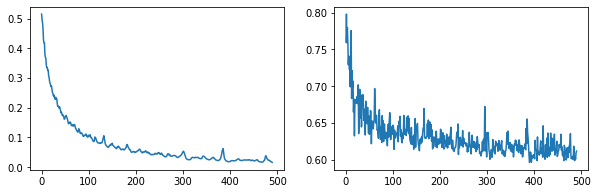

In [14]:
fig, ax = plt.subplots(1,2, figsize=(10,3))

ax[0].plot(train_history[10:])
ax[1].plot(val_history[10:])

In [15]:
model.eval()
loss = 0.
for i in np.random.permutation(len(test_data)//batch_size):
    start, end = i*batch_size, (i+1)*batch_size
    x,z = test_data[start:end].cuda(), test_targets[start:end].cuda()
    loss += ((model(x).detach() - z)**2).view(-1,64*64).sum(1).mean()
print('Final Loss: {:2f}'.format(loss/(len(test_data)//batch_size)))

Final Loss: 38.653519


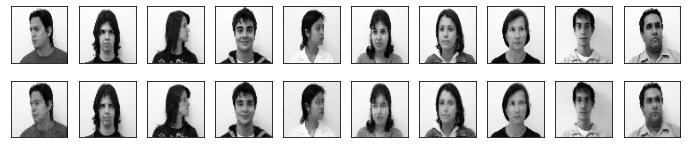

In [16]:
fig, ax = plt.subplots(2,10, figsize=(12,2.5))

model.eval()
reconstructions = model(train_data[0:10].cuda()).detach().cpu()
for i in range(10):
    ax[0,i].imshow(train_targets[i],cmap='Greys_r')
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([])
    
    ax[1,i].imshow(reconstructions[i],cmap='Greys_r')
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([])

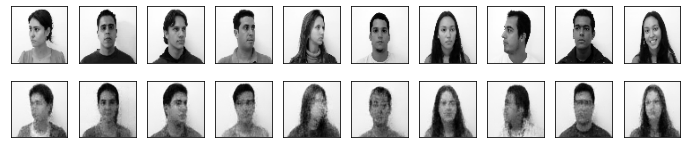

In [17]:
fig, ax = plt.subplots(2,10, figsize=(12,2.5))

model.eval()
reconstructions = model(test_data[0:10].cuda()).detach().cpu()
for i in range(10):    
    ax[0,i].imshow(test_targets[i],cmap='Greys_r')
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([])
    
    ax[1,i].imshow(reconstructions[i],cmap='Greys_r')
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([])